In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
from VariationalBayes.SparseObjectives import \
    Objective, pack_csr_matrix

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import autograd

import copy
from scipy import optimize

import os
import json

import time

import pickle


In [2]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.

simulate_data = False

if not simulate_data:
    analysis_name = 'simulated_data_small'
    #analysis_name = 'criteo_subsampled'

    data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                            'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')
    json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)
    y_g_vec, y_vec, x_mat, glmm_par, prior_par = logit_glmm.load_json_data(json_filename)
    
    K = x_mat.shape[1]
    NG = np.max(y_g_vec) + 1

else:
    # Generate data
    N = 200     # observations per group
    K = 5      # dimension of regressors
    NG = 200      # number of groups

    true_beta = np.array(range(5))
    true_beta = true_beta - np.mean(true_beta)
    true_mu = 0.
    true_tau = 40.0

    x_mat, y_g_vec, y_vec, true_rho, true_u = \
        logit_glmm.simulate_data(N, NG, true_beta, true_mu, true_tau)
    prior_par = logit_glmm.get_default_prior_params(K)
    glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)


print(np.mean(y_vec))

dict_keys(['y_group', 'N', 'NG', 'x', 'mu_prior_info', 'tau_prior_beta', 'K', 'beta_prior_mean', 'beta_prior_info', 'mu_prior_mean', 'y', 'tau_prior_alpha'])
0.324


In [3]:
# Initialize.

if False:
    # Slightly smarter inits would probably improve fit time, but as of now it doesn't
    # seem worth explaining in the paper.
    import pandas as pd
    #print(glmm_par)

    x_t_x = np.matmul(x_mat.transpose(), x_mat)
    x_t_y = np.matmul(x_mat.transpose(), y_vec)
    beta_init = np.linalg.solve(x_t_x, x_t_y)
    #print(beta_init)
    #plt.plot(sp.special.expit(np.matmul(x_mat, beta_init)), y_vec, 'k.')

    df = pd.DataFrame({ 'y_g': y_g_vec, 'y': y_vec}).groupby('y_g')
    #print(df.sum())
    u_init = np.array(df.sum()) / np.array(df.count()['y'])
    #plt.figure()
    print(np.min(y_g_vec))
    #plt.plot(u_init[y_g_vec], y_vec, 'k.')

glmm_par['mu']['mean'].set(0.0)
glmm_par['mu']['info'].set(1.0)

glmm_par['tau']['shape'].set(2.0)
glmm_par['tau']['rate'].set(2.0)

glmm_par['beta']['mean'].set(np.full(K, 0.0))
#glmm_par['beta'].info.set(np.eye(K))
glmm_par['beta']['info'].set(np.ones(K))

glmm_par['u']['mean'].set(np.full(NG, 0.0))
glmm_par['u']['info'].set(np.full(NG, 1.0))

free_par_vec = glmm_par.get_free()
init_par_vec = copy.deepcopy(free_par_vec)


In [4]:
# Define moment parameters
moment_wrapper = logit_glmm.MomentWrapper(glmm_par)
moment_jac = moment_wrapper.get_moment_jacobian(init_par_vec)


In [5]:
model = logit_glmm.LogisticGLMM(glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points=4)
model.get_e_log_prior()
model.get_log_lik()
model.get_entropy()

model.objective.fun_free(free_par_vec)

import timeit

time_num = 10

num_draws = 3
model.set_gh_points(num_draws)
print('num_draws = ', num_draws)
print('\tFunction time:',
      timeit.timeit(lambda: model.objective.fun_free(free_par_vec), number=time_num) / time_num)

print('\tGrad time:', 
      timeit.timeit(lambda: model.objective.fun_free_grad(free_par_vec), number=time_num) / time_num)

print('\tHessian vector product time:',
      timeit.timeit(lambda: model.objective.fun_free_hvp(free_par_vec, free_par_vec + 1), number=time_num) / time_num)

prior_vec = model.prior_par.get_vector()
prior_hess_time = time.time()
model.get_prior_hess(prior_vec, init_par_vec)
prior_hess_time = time.time() - prior_hess_time
print('\tPrior hess time: ', prior_hess_time)

sparse_model = logit_glmm.SparseModelObjective(
    model.glmm_par, model.prior_par, model.x_mat, model.y_vec, model.y_g_vec,
    model.num_gh_points, num_groups=1)



num_draws =  3
	Function time: 0.0005080893984995783
	Grad time: 0.004943348499364219
	Hessian vector product time: 0.013280399699578994
	Prior hess time:  0.05856823921203613


In [6]:
glmm_par_opt = copy.deepcopy(glmm_par)

def get_moment_vec(vb_opt_x):
    glmm_par_opt.set_free(vb_opt_x)
    set_moments(glmm_par_opt, moment_par)
    return moment_par.get_vector()


In [7]:
# Optimize.

print('Running Newton Trust Region.')
num_gh_points = 4
vb_time = time.time()
vb_opt = model.tr_optimize(init_par_vec, num_gh_points, gtol=1e-6, maxiter=500)
opt_x = vb_opt.x
vb_time = time.time() - vb_time

print('VB time: ', vb_time)
print('Done.')

Running Newton Trust Region.
Iter  0  value:  1034.44059918
Iter  5  value:  235.257298461
Iter  10  value:  72.6398068113
Iter  15  value:  69.409569197
Optimization terminated successfully.
         Current function value: 69.407873
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
         Hessian evaluations: 0
VB time:  2.2258026599884033
Done.


In [8]:

glmm_par.set_free(opt_x)
if simulate_data:
    print('Fit beta: ', glmm_par['beta'].e())
    print('True beta: ', true_beta)
    
    print('Fit mu: ', glmm_par['mu'].e())
    print('True mu: ', true_mu)
    
    print('Fit tau: ', glmm_par['tau'].e())
    print('True tau: ', true_tau)
    
    plt.plot(true_u, true_u, 'r.')
    plt.plot(true_u, glmm_par['u'].e(), 'k.')
    

VB time:  2.2258026599884033


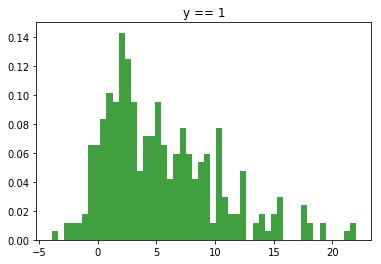

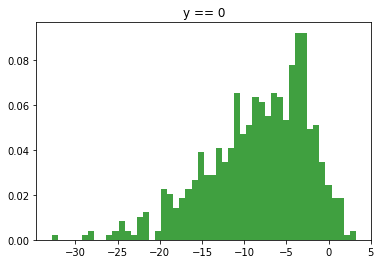

In [9]:
print('VB time: ', vb_time)

import scipy as sp

glmm_par_opt = copy.deepcopy(glmm_par)
glmm_par_opt.set_free(opt_x)

e_beta = glmm_par_opt['beta'].e()
e_u = glmm_par_opt['u'].e()[model.y_g_vec]

z_mean = e_u + np.matmul(model.x_mat, e_beta)

plt.figure()
plt.hist(z_mean[model.y_vec == 1], 50, normed=1, facecolor='green', alpha=0.75)
plt.title('y == 1')

plt.figure()
plt.hist(z_mean[model.y_vec == 0], 50, normed=1, facecolor='green', alpha=0.75)
plt.title('y == 0')




In [10]:
# # In case you want to save without calculating the Hessian, instantiate them here
if False:
    hess_time = 0.
    log_prior_hess = np.array([0.])
    elbo_hess = np.array([0.])
    moment_jac = np.array([0.])
    lrvb_cov = np.array([0.])

In [11]:
# Get the Hessians at the number of draws used for optimization
# sparse_model = logit_glmm.SparseModelObjective(
#     glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points, num_groups=1)

model.glmm_par.set_free(opt_x)

hess_time = time.time()
print('KL Hessian...\n')
sparse_vector_hess = \
    sparse_model.get_sparse_vector_hessian(print_every_n=100)
elbo_hess = sparse_model.get_free_hessian(sparse_vector_hess)

print('Log prior Hessian...\n')
log_prior_hess = model.get_prior_hess(prior_par.get_vector(), opt_x)

moment_jac = moment_wrapper.get_moment_jacobian(opt_x)

hess_time =  time.time() - hess_time

print('hess_time: %f' % hess_time)

KL Hessian...

Calculating global hessian:
Calculating local hessian:
Group 0 of 99.


/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Log prior Hessian...

hess_time: 8.811845


In [12]:
print('Solving systems...\n')
inverse_time = time.time()
from scikits.sparse.cholmod import cholesky
elbo_hess_chol = cholesky(elbo_hess)
elbo_inv_moment_jac = -1 * elbo_hess_chol.solve_A(moment_jac.T)
lrvb_cov = np.matmul(moment_jac, elbo_inv_moment_jac)
vb_prior_sens = np.matmul(log_prior_hess, elbo_inv_moment_jac).T

inverse_time = time.time() - inverse_time
print('Done\n')

print('Inverse time:', inverse_time)

Solving systems...

Done

Inverse time: 0.008187294006347656


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  after removing the cwd from sys.path.


In [13]:
#print('Solving systems...\n')
#lrvb_cov = -1 * np.matmul(moment_jac, np.linalg.solve(elbo_hess, moment_jac.T))
# elbo_inv_moment_jac = -1 * sp.sparse.linalg.spsolve(elbo_hess, moment_jac.T)
#print('Done\n')

In [14]:
if True:
    old_inv_time = time.time()
    elbo_inv_moment_jac_solve = -1 * sp.sparse.linalg.spsolve(elbo_hess, moment_jac.T)
    old_inv_time = time.time() - old_inv_time

    print('Difference:', np.linalg.norm(elbo_inv_moment_jac_solve - elbo_inv_moment_jac))
    print('Old time: ', old_inv_time)

Difference: 5.64263313801e-16
Old time:  0.008536577224731445


In [15]:
# Time using conjugate gradient to get a single row of the moment sensitivity.
import scipy as sp
from scipy.sparse.linalg import LinearOperator

class OptimumHVP(object):
    def __init__(self, glmm_par, opt_x, moment_jac):
        self.verbose = False
        self.print_every = 10
        self.reset_iter()
        self.opt_x = opt_x
        self.moment_jac = moment_jac
        self.lo = LinearOperator(
            (glmm_par.free_size(), glmm_par.free_size()), self.hvp)
        
    def reset_iter(self):
        self.iter = 0
    
    def hvp(self, vec):
        self.iter += 1
        if self.verbose and self.iter % self.print_every == 0:
            print('Iter ', self.iter)
        return model.objective.fun_free_hvp(self.opt_x, vec)
    
    def get_moment_sensitivity_row(self, moment_row):
        self.reset_iter()
        moment_jac_vec = moment_jac[moment_row, :].flatten()
        cg_res, info = sp.sparse.linalg.cg(self.lo, moment_jac_vec)
        return cg_res, info

moment_row = 0
optimum_hvp = OptimumHVP(glmm_par, opt_x, moment_jac)
optimum_hvp.verbose = True
optimum_hvp.print_every = 20
cg_row_time = time.time()
cg_res, info = optimum_hvp.get_moment_sensitivity_row(0)
cg_row_time = time.time() - cg_row_time

print('CG time: ', cg_row_time)
num_cg_iterations = optimum_hvp.iter
print('Number of iterations: ', optimum_hvp.iter)

print(np.max(np.abs(cg_res - elbo_inv_moment_jac[:, moment_row].flatten())))

Iter  20
CG time:  0.3514587879180908
Number of iterations:  23
0.0584545098444


In [16]:
if not simulate_data:
    # Write the result to a JSON file for use in R.
    
    run_name = 'production'
    
    pickle_output_filename = os.path.join(data_dir, '%s_python_vb_results.pkl' % analysis_name)
    pickle_output = open(pickle_output_filename, 'wb')

    # Unlike with JSON, numpy arrays can be pickled.
    # Note that it does not seem that you can pickle a sparse Cholesky decomposition.
    pickle_result_dict = {  'glmm_par_dictval': glmm_par_opt.dictval(),
                            'glmm_par_vector': glmm_par_opt.get_vector(),
                            'glmm_par_free': glmm_par_opt.get_free(),
                            'run_name': run_name,
                            'vb_time': vb_time,
                            'hess_time': hess_time,
                            'inverse_time': inverse_time,
                            'cg_row_time': cg_row_time,
                            'num_cg_iterations': num_cg_iterations,
                            'num_gh_points': num_gh_points, 
                            'lrvb_cov': np.squeeze(lrvb_cov),
                            'moment_jac': np.squeeze(moment_jac),
                            'elbo_inv_moment_jac': elbo_inv_moment_jac,
                            'elbo_hess_packed': pack_csr_matrix(elbo_hess),
                            'sparse_vector_hess_packed': pack_csr_matrix(sparse_vector_hess),
                            'vb_prior_sens': np.squeeze(vb_prior_sens),
                            'log_prior_hess': np.squeeze(log_prior_hess) }

    # Pickle dictionary using protocol 0.
    pickle.dump(pickle_result_dict, pickle_output)
    pickle_output.close()
    
    print(pickle_output_filename)


print('\n\nDONE.')
    

/home/rgiordan/Documents/git_repos/LinearResponseVariationalBayes.py/Models/LogisticGLMM/data/simulated_data_small_python_vb_results.pkl


DONE.
